In [1]:
import sys
sys.path.append("../../")  # access to local modules

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from scipy.ndimage import shift
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint, uniform
from sklearn.svm import SVR

In [3]:
from MLDemo import DataPulling
from MLDemo.DataVisualization import pipelines

In [4]:
TRAIN_NUMBER: int = 60000  # number of training data entries
RANDOM_STATE: int = 42  # initial random state

In [5]:
x, y = DataPulling.get_mnist()
print(x.shape, y.shape)

(70000, 784) (70000,)


In [6]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

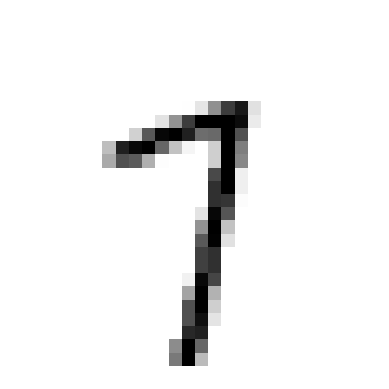

In [7]:
# see if it works

plot_digit(x[42])
plt.show()

In [8]:
x_train, x_test = x[:TRAIN_NUMBER], x[TRAIN_NUMBER:]
y_train, y_test = y[:TRAIN_NUMBER], y[TRAIN_NUMBER:]

## Singleclass Classifiers

In [9]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [10]:
sgd_clf = SGDClassifier(random_state=RANDOM_STATE)
sgd_clf.fit(x_train, y_train_5)
print(sgd_clf.predict([x[0], x[42]]))  # should be [True, False]

[ True False]


In [11]:
cross_validation = cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")
print(cross_validation)

[0.95035 0.96035 0.9604 ]


In [12]:
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[53892   687]
 [ 1891  3530]]


In [13]:
print(f"Precision:", precision_score(y_train_5, y_train_pred))
print(f"Recall:", recall_score(y_train_5, y_train_pred))
print(f"F1 score: ", f1_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1 score:  0.7325171197343847


In [14]:
y_scores = sgd_clf.decision_function([x[0], x[42]])
print(y_scores)

[ 2164.22030239 -2025.22354318]


In [15]:
# full y scores
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

In [16]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

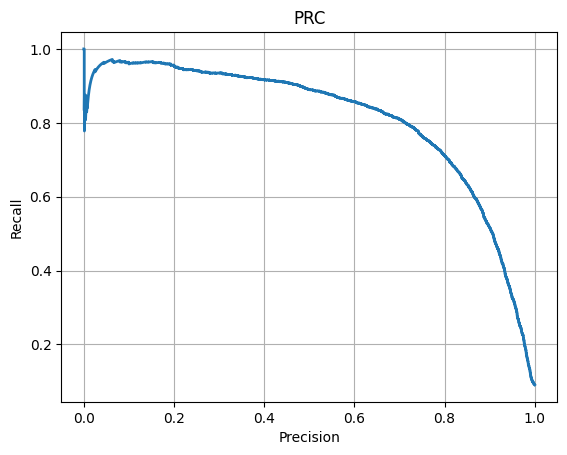

In [17]:
plt.plot(recalls, precisions, linewidth=2, label="Precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PRC")
plt.grid(True)
plt.show()

In [18]:
idx_90_precision = (precisions >= 0.9).argmax()
threshold = thresholds[idx_90_precision]
print(threshold)

3370.0194991439557


In [19]:
y_train_pred_90 = (y_scores >= threshold)
print("Precision:", precision_score(y_train_5, y_train_pred_90), "\nRecall:", recall_score(y_train_5, y_train_pred_90))

Precision: 0.9000345901072293 
Recall: 0.4799852425751706


In [20]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

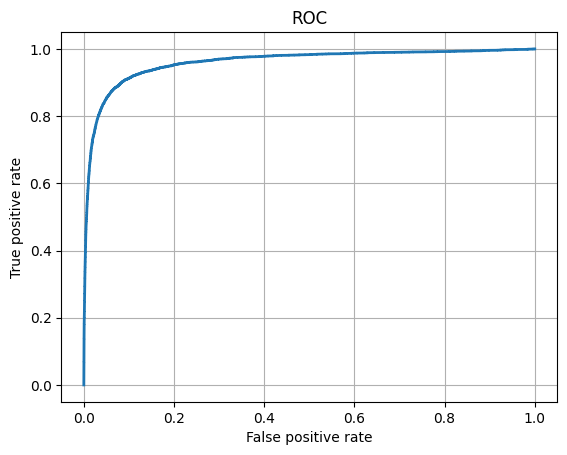

In [21]:
plt.plot(fpr, tpr, linewidth=2, label="eceiver operationg characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC")
plt.grid(True)
plt.show()

In [22]:
print("AUC:", roc_auc_score(y_train_5, y_scores))

AUC: 0.9604938554008616


In [23]:
forest_clf = RandomForestClassifier(random_state=RANDOM_STATE)
y_prob_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")
# precition false - true

print(y_prob_forest[:2])

[[0.11 0.89]
 [0.99 0.01]]


In [24]:
y_scores_forest = y_prob_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

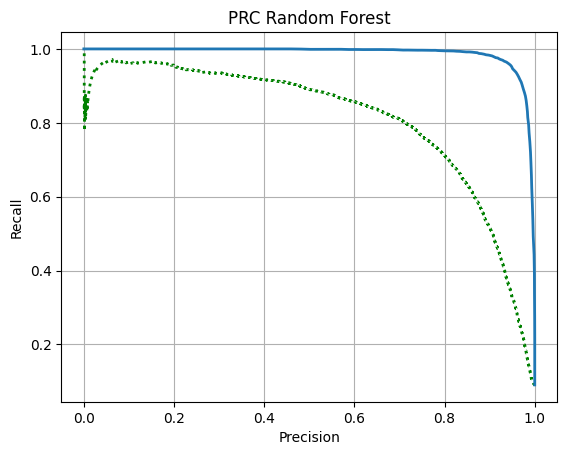

In [25]:
plt.plot(recalls, precisions, "g:", linewidth=2, label="Precision recall curve")
plt.plot(recalls_forest, precisions_forest, linewidth=2, label="Precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PRC Random Forest")
plt.grid(True)
plt.show()

## Multiclass classifiers

In [26]:
svm_clf = SVC(random_state=42)
svm_clf.fit(x_train[:2000], y_train[:2000])

SVC(random_state=42)

In [27]:
svm_clf.predict([x[0]])

array(['5'], dtype=object)

In [28]:
some_scores = svm_clf.decision_function([x[0]])
print(some_scores.round(2))

[[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]


In [29]:
svm_clf.classes_  # to see the class labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [30]:
ovr_clf = OneVsRestClassifier(SVC(random_state=RANDOM_STATE))
ovr_clf.fit(x_train[:2000], y_train[:2000])
print("One vs rest SVC:", ovr_clf.predict([x[0]]))

One vs rest SVC: ['5']


In [31]:
sgd_clf = SGDClassifier(random_state=RANDOM_STATE)
sgd_clf.fit(x_train, y_train)
print("One vs rest SGD:", sgd_clf.predict([x[0]]))

One vs rest SGD: ['3']


In [32]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype('float64'))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [33]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)

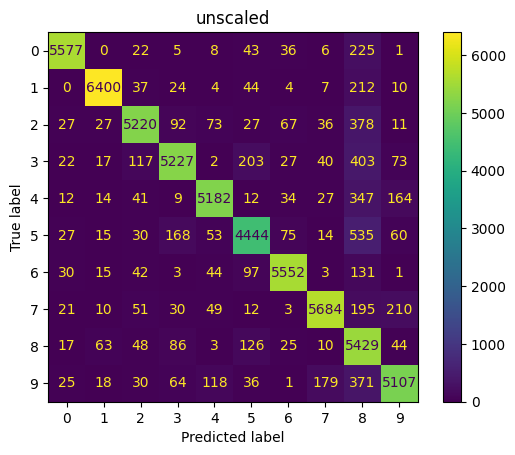

In [34]:
# unscaled
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("unscaled")
plt.show()

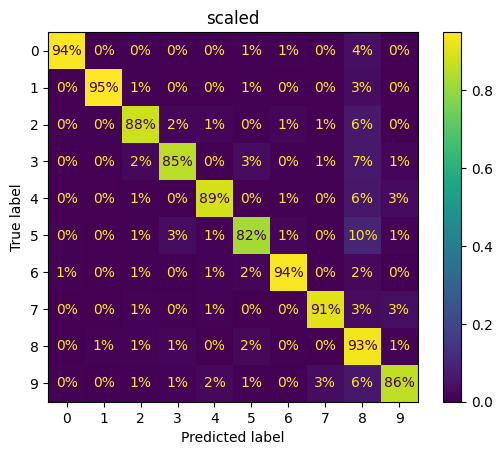

In [35]:
# scaled
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.title("scaled")
plt.show()

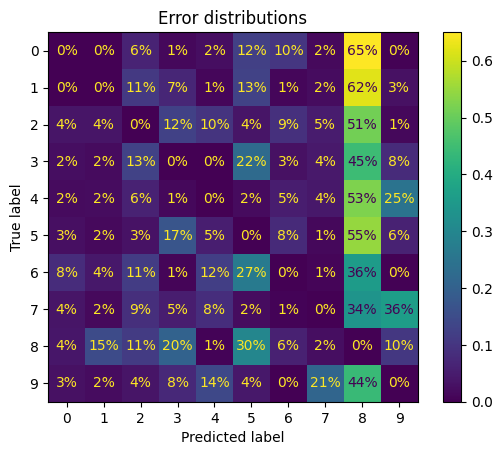

In [36]:
# scale colours to show error intensities
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.title("Error distributions")
plt.show()

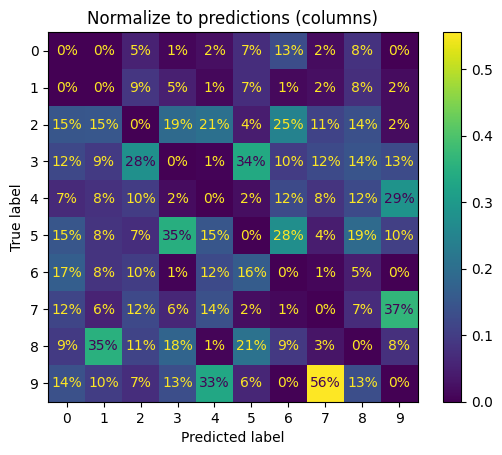

In [37]:
# normalize to predictions
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%")
plt.title("Normalize to predictions (columns)")
plt.show()

## Multilabel classification

In [38]:
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [39]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [40]:
print([y_train[0], y_train[42]])
print(knn_clf.predict([x[0], x[42]]))

['5', '7']
[[False  True]
 [ True  True]]


In [41]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

0.9764102655606048


In [42]:
print(f1_score(y_multilabel, y_train_knn_pred, average="weighted"))

0.9778357403921755


In [43]:
# chained results
chain_clf = ClassifierChain(SVC(), cv=3, random_state=RANDOM_STATE)
chain_clf.fit(x_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [44]:
chain_clf.predict([x[0]])

array([[0., 1.]])

## Multioutput classification

In [45]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

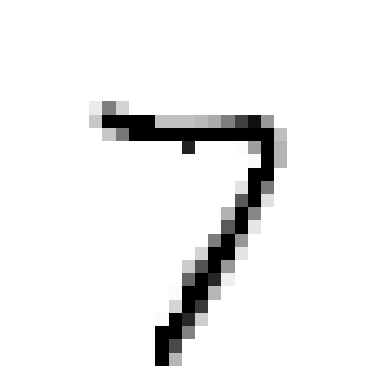

In [46]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[0]])
plot_digit(clean_digit)
plt.show()

## Exercises

### E1

In [47]:
knn_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [48]:
param_grid = [
    {
        "n_neighbors": [4, 5, 7],
        "weights": ["uniform", "distance"]
    }
]

In [49]:
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [4, 5, 7],
                          'weights': ['uniform', 'distance']}])

In [50]:
final_model = grid_search.best_estimator_
print("best parameters:", best_params := grid_search.best_params_)
print("Best score:", best_score := grid_search.best_score_)

best parameters: {'n_neighbors': 4, 'weights': 'distance'}
Best score: 0.9716166666666666


### E2

In [51]:
def shift_image(image, dx, dy):
    image = image.reshape([28, 28])
    shifted_image = shift(image, [dx, dy], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [52]:
x_train_augmented = [image for image in x_train]
y_train_augmented = [label for label in y_train]

for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
    for image, label in zip(x_train, y_train):
        x_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [53]:
shuffle_idx = np.random.permutation(len(x_train_augmented))
x_train_augmented = x_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [54]:
best_knn = KNeighborsClassifier(**best_params)

In [55]:
best_knn.fit(x_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [56]:
print(augmented_accuracy := best_knn.score(x_test, y_test))

0.9763


### E3

In [57]:
titanic_raw: pd.DataFrame = DataPulling.open_tgz(DataPulling.TITANIC)[0][1]

In [58]:
titanic_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
titanic_label = titanic_raw["Survived"].copy()
titanic_data = titanic_raw[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]].copy()
titanic_data.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [60]:
titanig_train

0.0 512.3292


In [80]:
preprocessing = ColumnTransformer([
    ("Pclass", pipelines.cat_pipeline(), ["Pclass"]),
    ("Sex", pipelines.cat_pipeline(), ["Sex"]),
    ("Age", pipelines.standardize_pipeline(), ["Age"]),
    ("SibSp", pipelines.cat_pipeline(), ["SibSp"]),
    ("Parch", pipelines.cat_pipeline(), ["Parch"]),
    ("Fare", pipelines.standardize_pipeline(), ["Fare"]),
    ("Embarked", pipelines.cat_pipeline(), ["Embarked"])
], remainder="drop")

In [81]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("selector", SelectFromModel(estimator=RandomForestRegressor(), threshold = 0.005)),
    ("KNN", KNeighborsClassifier())
])

In [82]:
full_pipeline.fit(titanic_data, titanic_label)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Pclass',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass']),
                                                 ('Sex',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ig...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Fare']),
                                                 ('Embarked',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked'])])),
                ('selector',
                 SelectFromModel(estimator=RandomForestRegressor(),
                                 threshold=0.005)),
                ('KNN', KNeighborsClassifier())])

In [83]:
full_pipeline.predict(titanic_data)

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,